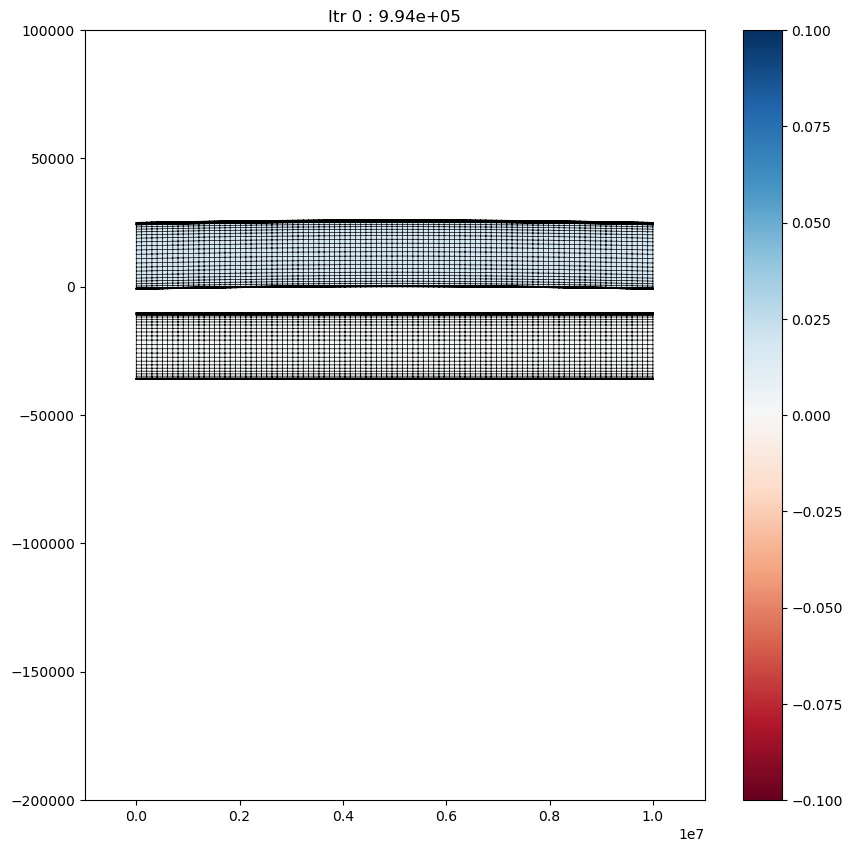

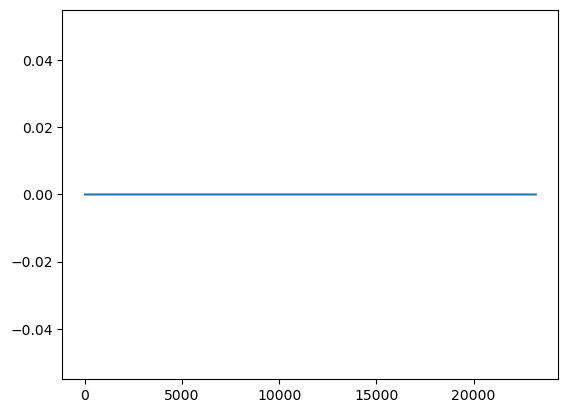

KeyboardInterrupt: 

In [173]:
from skfem import *
from skfem.experimental.autodiff import *
from skfem.experimental.autodiff.helpers import *
from skfem.supermeshing import intersect, elementwise_quadrature
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from jax import device_get
from datetime import datetime
from scipy.sparse.linalg import norm
import os
from functools import partial

def focused_linspace(ymin, ymax, n_element, focus='center', sharpness=5.0):
    """
    집중 분포된 linspace 생성기.
    
    Parameters
    ----------
    ymin, ymax : float
        구간 경계
    n_element : int
        총 분할 수
    focus : str ['center', 'ymin', 'ymax', 'edge']
        집중할 위치 ('edge'는 양 끝)
    sharpness : float
        집중 정도 (클수록 더 집중됨)

    Returns
    -------
    y : np.ndarray
        위치 배열 (n_element 개)
    """
    u = np.linspace(-1, 1, n_element)

    if focus == 'center':
        w = 0.5 * (1 + np.tanh(sharpness * u) / np.tanh(sharpness))
    elif focus == 'ymin':
        w = (np.exp(sharpness * u) - 1) / (np.exp(sharpness) - 1)
    elif focus == 'ymax':
        w = (np.exp(sharpness * (u + 1)) - 1) / (np.exp(sharpness * 2) - 1)
    elif focus == 'edge':
        # 가운데 느슨하게, 양쪽 촘촘하게
        w = 0.5 * (1 - np.tanh(sharpness * u) / np.tanh(sharpness))
    else:
        raise ValueError("focus must be one of: 'center', 'ymin', 'ymax', 'edge'")

    return ymin + w * (ymax - ymin)

def moving_average_x(xs, values, window_x):
    """
    x 좌표 기준으로 이동평균 수행
    """
    averaged = np.zeros_like(values)
    for i, xi in enumerate(xs):
        mask = np.abs(xs - xi) <= window_x / 2
        if np.any(mask):
            averaged[i] = np.mean(values[mask])
        else:
            averaged[i] = values[i]  # fallback
    return averaged

def curvature_based_resample(xs, ys, n_points = 100, baseline_weight=1.0, eps=1e-10, window_x = 5):
    """
    곡률 기반으로 xs를 재분포하되, 곡률이 0일 때도 기본 밀도 유지.

    Parameters
    ----------
    xs : np.ndarray
        원래 x 좌표
    ys : np.ndarray
        대응하는 y 값
    n_points : int
        재분포할 점 수
    baseline_weight : float
        곡률이 0일 때 기본으로 주는 weight 비율 (기본값=1.0, 즉 곡률 없는 영역도 분할함)
    eps : float
        0 나눔 방지용 소수

    Returns
    -------
    xs_refined : np.ndarray
        곡률 기반으로 재분포된 x좌표
    """
    
    
    # 1차 및 2차 미분
    dy = np.gradient(ys, xs)
    d2y = np.gradient(dy, xs)

    # 곡률 기반 weight + 기본 weight 혼합
    curvature_weight = moving_average_x(xs, np.abs(d2y), window_x)
    weight = curvature_weight + baseline_weight + eps  # baseline 유지
    weight /= np.sum(weight)  # 정규화

    # 누적 분포 함수
    cdf = np.cumsum(weight)
    

    
    cdf = (cdf - cdf[0]) / (cdf[-1] - cdf[0])  # normalize to [0, 1]

    """
    #좌우 대칭
    if len(cdf) % 2 == 0:
        cdf[len(cdf)//2:] = 1 - cdf[:len(cdf)//2][::-1]
    else:
        cdf[len(cdf)//2+1:] = 1 - cdf[:len(cdf)//2][::-1]
        cdf[len(cdf)//2] = 0.5
    """
    
    # 역보간으로 새 xs 생성
    inv_cdf = interp1d(cdf, xs, kind='linear', fill_value='extrapolate')
    xs_refined = inv_cdf(np.linspace(0, 1, n_points))
    

    return xs_refined


def create_alpine(xs, center_x, amplitude, half_width):
    mask = np.ones_like(xs)
    ys = amplitude/2 + amplitude/2 * np.cos((xs - center_x) * np.pi / half_width )
    mask[xs > (center_x + half_width)] = 0
    mask[xs < (center_x - half_width)] = 0
    ys = ys * mask
    return ys

def deform_top_surface(mesh, top_deformations, ny, direction = 'top'):
    """Deform the mesh while preserving vertical ordering and fixing the bottom surface
    
    Args:
        mesh: The mesh to deform
        top_deformations: Array of target deformations for each point on the top surface
        amplitude: Maximum deformation amplitude
    """
    n_layers = ny

    # Apply deformation to all layers except the bottom
    for i in range(n_layers):  # Exclude the bottom layer
        # Find nodes in this layer
        layer_nodes = np.arange(i, len(mesh.p[0]), ny)
        # Calculate deformation for this layer
        # Amplitude decreases linearly from top to bottom
        # The bottom layer (i = n_layers-2) will have zero deformation
        if direction == 'top':
            layer_amplitude = i / (n_layers - 1)  # Adjusted for bottom layer exclusion
            deformation = top_deformations * layer_amplitude
        else:
            layer_amplitude = (n_layers - i) / (n_layers - 1)  # Adjusted for bottom layer exclusion
            deformation = top_deformations * layer_amplitude
        
        # Apply deformation
        mesh.p[1, layer_nodes] += deformation
        
def merge_array(*arrs):
    return np.sort(np.unique(np.concatenate(arrs)))

def generate_layer(layers, ny):
    ys_list = []
    for (start, end), material in layers.items():
        ys_list.append(focused_linspace(start, end, ny, focus = 'edge', sharpness =1))
    return ys_list

def generate_material(m, layers):
    y_elem = m.p[1, m.t].mean(axis=0)
    material_id = np.zeros_like(y_elem)
    for (start, end), material in layers.items():
        material_id[np.logical_and(y_elem >= start, y_elem <= end)] = material
    return material_id

def generate_stress(m, layers):
    y_elem = m.p[1, m.t].mean(axis=0)
    stress_elem = np.zeros_like(y_elem)
    for (start, end), stress in layers.items():
        stress_elem[np.logical_and(y_elem >= start, y_elem <= end)] = stress
    return stress_elem

class Chip:
    def __init__(self, top_topology, bottom_topology, xs_refined, ny_layer, material_layers, stress_layers):
        self.width = xs_refined.max() - xs_refined.min()
        self.top_topology = top_topology
        self.bottom_topology = bottom_topology
        
        max_height = 0
        min_height = 0
        for (start, end), material in material_layers.items():
            if start < min_height:
                min_height = start
            if end > max_height:
                max_height = end
        self.height = max_height - min_height
        
        self.xs = xs_refined
        self.ys = merge_array(*generate_layer(material_layers, ny))
        self.mesh = MeshQuad.init_tensor(self.xs, self.ys).with_defaults()
        self.material = generate_material(self.mesh, material_layers)
        
        self.stress = generate_stress(self.mesh, stress_layers)
        self.stress_elem = np.zeros((2,2,len(self.material)))
        self.stress_elem[0,0,:] = self.stress
        
        self.modulus = np.array([material_properties[material]['modulus'] for material in self.material])
        self.nu = np.array([material_properties[material]['poisson_ratio'] for material in self.material])
        self.lam = self.modulus * self.nu / ((1 + self.nu) * (1 - 2 * self.nu))
        self.lam_elem = self.lam[np.newaxis,np.newaxis,:,np.newaxis ]
        self.mu = self.modulus / 2 / (1 + self.nu)
        self.mu_elem = self.mu[np.newaxis,np.newaxis,:,np.newaxis]
        
        self.basis = Basis(self.mesh, ElementVector(ElementQuad1()))
        self.pbasis = self.basis.with_element(ElementQuad0())
        self.u = np.zeros(self.basis.N)
        
        deform_top_surface(self.mesh, top_topology(self.xs), len(self.ys), direction = 'top')
        deform_top_surface(self.mesh, bottom_topology(self.xs), len(self.ys), direction = 'bottom')

    
    def translate(self, u):
        self.mesh = self.mesh.translated(u)
        self.top_topology = interp1d(self.xs, self.top_topology(self.xs) + u[1], kind='cubic', fill_value='extrapolate')
        self.bottom_topology = interp1d(self.xs, self.bottom_topology(self.xs) + u[1], kind='cubic', fill_value='extrapolate')
        self.u = self.u
    
    def plot(self, item, ax = None):
        if ax is None:
            fig,ax = plt.subplots(figsize=(10,10))
        self.mesh.plot(self.__getattribute__(item), ax = ax)
        self.mesh.draw(ax = ax)
        
        
    def intersect(self, chip):
        m1defo = self.mesh.translated(self.u[self.basis.nodal_dofs])
        m2defo = chip.mesh.translated(chip.u[chip.basis.nodal_dofs])
        m1t, orig1 = m1defo.trace('bottom', mtype=MeshLine, project=lambda p: np.array(p[0]))
        m2t, orig2 = m2defo.trace('top', mtype=MeshLine, project=lambda p: np.array(p[0]))

        # 공통 xmin, xmax 계산
        xmin = min(m1t.p[0].min(), m2t.p[0].min())
        xmax = max(m1t.p[0].max(), m2t.p[0].max())

        m1t.p[0][-1] = xmax
        m2t.p[0][-1] = xmax
        m1t.p[0][0] = xmin
        m2t.p[0][0] = xmin
        
        m12, t1, t2 = intersect(m1t, m2t)

        fbasis1 = FacetBasis(self.mesh, ElementVector(ElementQuad1()), quadrature=elementwise_quadrature(m1t, m12, t1), facets=orig1[t1])
        fbasis2 = FacetBasis(chip.mesh, ElementVector(ElementQuad1()), quadrature=elementwise_quadrature(m2t, m12, t2), facets=orig2[t2])
        fbasis = fbasis1 * fbasis2    
        
        return fbasis
        
    @property
    def u(self):
        return self._u
    
    @u.setter
    def u(self, value):
        self._u = value
        self.mesh_defo = self.mesh.translated(value[self.basis.nodal_dofs])
        self.u_elem = self.basis.interpolate(value)
        self.u_elem_x = self.u_elem[0]
        self.u_elem_y = self.u_elem[1]
        
        # 변형률 field
        self.e = 0.5 * (grad(self.u_elem) + transpose(grad(self.u_elem)) + mul(transpose(grad(self.u_elem)), grad(self.u_elem)))

        # 응력 field (선형 탄성)
        self.sigma = 2 * self.mu_elem * self.e + self.lam_elem * eye(trace(self.e), 2)
        
        # 원하는 응력 성분 예: sigma_yy
        self.sigma_yy = self.pbasis.project(np.array(self.sigma[1, 1]))
        self.sigma_xx = self.pbasis.project(np.array(self.sigma[0, 0]))
        self.sigma_xy = self.pbasis.project(np.array(self.sigma[0, 1]))
        self.sigma_yx = self.pbasis.project(np.array(self.sigma[1, 0]))       
        
    @property
    def top_y(self):
        return self.mesh.p[1].max()
    
    @property
    def bottom_y(self):
        return self.mesh.p[1].min()
    
    @property
    def center_x(self):
        return (self.xs.max() + self.xs.min()) / 2
    
    @property
    def elastic_energy(self):
        @NonlinearForm(hessian=True)
        def J(u,w):
            eps = 0.5 * (grad(u) + transpose(grad(u)) + mul(transpose(grad(u)), grad(u)))
            sig = 2 * self.mu_elem * eps + self.lam_elem * eye(trace(eps), 2)
            return 0.5 * ddot(sig - self.stress_elem[:,:,:,np.newaxis], eps)    
        return J
    
    def assemble(self):
        return self.elastic_energy.assemble(self.basis, x = self.u)
    
    def plot_defo(self, ax = None, overlay = []):
        if ax is None:
            fig,ax= plt.subplots(figsize = (10,10))
        
        pbasis_defo = Basis(self.mesh_defo, ElementQuad0())
        self.mesh_defo.draw(ax = ax)

        for item in overlay:
            pbasis_defo.plot(self.__getattribute__(item), ax = ax, cmap = 'RdBu')
            
        return ax
    
    def get_dofs(self, item):
        return self.u[self.basis.get_dofs(item).all()[1::2]]  
             
class Bonding:
    def __init__(self, chip_top, chip_bottom, **kwargs):
        self.chip_bottom = chip_bottom
        self.chip_top = chip_top
        self.potential_params = kwargs
        
        def morse_potential(g, gamma , g0 , a):
            energy = gamma * (jnp.exp(-2 * a * (g-g0)) - 2 * jnp.exp(-a * (g-g0)))
            g_cut = g0 + jnp.log(2)/a
            F_cut = gamma * (2 * a * jnp.exp(-2 * a * (g_cut - g0)) - 2 * a * jnp.exp(-a * (g_cut - g0)))
            E_cut = gamma * (jnp.exp(-2 * a * (g_cut - g0)) - 2 * jnp.exp(-a * (g_cut - g0)))       
            return jnp.where(g < (g0 + jnp.log(2)/a), energy , jnp.minimum(E_cut - F_cut * (g - g_cut), 0) )
        
        self.potential = partial(morse_potential, **self.potential_params)
        
        self.panalty =lambda g : max(chip_bottom.modulus)*1000*g**2
        
    def bonding_energy(self):
        @NonlinearForm(hessian=True)
        def g(u1, u2, w):
            xloc = w.x[0]
            y1_bottom = self.chip_top.bottom_topology(xloc)
            y2_top = self.chip_bottom.top_topology(xloc)
            local_gap = y1_bottom - y2_top
            gap_now = local_gap + u1[1] - u2[1]
            return self.potential(gap_now) + jnp.where(gap_now <= 0, self.panalty(gap_now), 0)
        return g
        
    def assemble(self):
        fbasis = self.chip_top.intersect(self.chip_bottom)
        jacg, rhsg = self.bonding_energy().assemble(fbasis, x=np.concatenate([self.chip_top.u, self.chip_bottom.u]))
        return jacg, rhsg

    @property
    def gap(self):
        fbasis = self.chip_top.intersect(self.chip_bottom)
        

#topology 프로파일 생성 
xs = np.linspace(0,1e-2,1000)
topology_top = create_alpine(xs, 0.5e-2, 5e-9, 1e-4)
#refine
xs_refined = curvature_based_resample(xs=xs, ys=topology_top, baseline_weight=0.1, n_points=100, window_x = 20)
topology_top_interp = interp1d(xs, topology_top, kind='cubic', fill_value='extrapolate')
topology_bottom_interp = interp1d(xs, np.zeros_like(xs), kind='cubic', fill_value='extrapolate')

#물질별 layer 지정
ny = 20
material_code = {1:'SICN', 2:'Si',3:'SIO2',4:'Si3N4', 5:'Glue'}
material_properties = {
    1: {'modulus': 200e9, 'poisson_ratio': 0.27},
    2: {'modulus': 130e9, 'poisson_ratio': 0.28},
    3: {'modulus': 70e9, 'poisson_ratio': 0.22}
}

fs_thk = 5000e-10
si_thk = 24.6e-6
bs_thk = 10000e-10

material_layers = {(0,fs_thk):1, (fs_thk,fs_thk+si_thk):2, (fs_thk+si_thk,fs_thk+si_thk+bs_thk):3}

stress_layers = {1 : {(0,fs_thk):-300e6, (fs_thk,fs_thk+si_thk):0, (fs_thk+si_thk,fs_thk+si_thk+bs_thk):210e6},
                 2 : {(0,fs_thk):0, (fs_thk,fs_thk+si_thk):0, (fs_thk+si_thk,fs_thk+si_thk+bs_thk):0}}

#units
L0 = 1e-9
m0 = 1
t0 = 1
P0 = m0/L0/t0**2 #pressure
rho0 = m0 / L0**3 #mass density
acc0 = L0/t0**2 #acceleration
vel0 = L0/t0 #velocity
gamma0 = m0 / t0**2 #surface energy

units = {'L' : L0,
         'm' : m0,
         't' : t0}

#scaling
topology_bottom = lambda x : topology_bottom_interp(x) / L0
topology_top = lambda x : topology_top_interp(x) / L0
xs_refined /= L0

for k,v in material_properties.items():
    material_properties[k]['modulus'] = v['modulus'] / P0

for i, stress_layers_chip in stress_layers.items():
    stress_layers_new = {}
    for k,v in stress_layers_chip.items():
        stress_layers_new[(k[0] / L0, k[1] / L0)] = v/P0
    stress_layers[i] = stress_layers_new       
    
material_layers_new = {}
for k,v in material_layers.items():
    material_layers_new[(k[0] / L0, k[1] / L0)] = v
material_layers = material_layers_new   
    
#make chip
chip1 = Chip(topology_top, topology_bottom, xs_refined, ny, material_layers, stress_layers[1])
chip2 = Chip(topology_top, topology_bottom, xs_refined, ny, material_layers, stress_layers[2])
chip2.translate([0, -chip2.top_y-10000])
bonding = Bonding(chip1, chip2, gamma = 0, g0 = 0, a = 10)

ax = chip1.plot('stress')
chip2.plot('stress',ax =ax)
plt.show()


def single_static_step(chip1, chip2, bonding, lr =1, du_max = 1):
    jac1, rhs1 = chip1.assemble()
    jac2, rhs2 = chip2.assemble()
    jacg, rhsg = bonding.assemble()
    
    
    dof_chip1_x_mid = chip1.basis.get_dofs('bottom').all()
    dof_chip1_x_mid = dof_chip1_x_mid[len(dof_chip1_x_mid)//2:len(dof_chip1_x_mid)//2+2]
    dof_chip2_y_bottom = (chip2.basis.get_dofs('bottom').all() + chip1.basis.N)[1::2]
    
    jac = bmat([[jac1, None], [None, jac2]]) + jacg
    rhs = np.concatenate((rhs1, rhs2)) + rhsg
    
    D = np.concatenate([dof_chip1_x_mid])#, dof_chip2_y_bottom])
    du = solve(*enforce(jac1, rhs1, D=D))
    
    lrp = lr * du_max / max(du_max, np.abs(du).max())
    
    chip1.u = chip1.u + du[:chip1.basis.N] * lrp
    #chip2.u = chip2.u + du[chip1.basis.N:] * lrp
    
    return chip1, chip2, bonding, np.linalg.norm(du), du.min(), du.max(), rhsg

from IPython.display import clear_output

def single_static_step_chip_warp(chip, lr =1):
    jac, rhs = chip.assemble_elastic_energy()
    i_mid = np.argmin(np.abs(chip.mesh.p[0] - (chip.xs.max()  + chip.xs.min()) / 2))
    
    dof_x_mid = chip.basis.get_dofs().all()[2*i_mid : 2*i_mid+2]
    print(dof_x_mid)
    D = np.concatenate([dof_x_mid])
    du = solve(*enforce(jac, rhs, D=D))
    
    chip.u = chip.u + du * lr
    
    return chip, np.linalg.norm(du), du.min(), du.max()

import json

for i in range(1000):
    learning_config = json.load(open('learning_config.json'))
    chip1, chip2, bonding, norm, min_u, max_u,rhsg = single_static_step(chip1, chip2, bonding, **learning_config)
    ax = chip2.plot_defo(overlay = ['stress'])
    ax = chip1.plot_defo(overlay = ['stress'], ax= ax)
    clear_output(wait=True)
    plt.title(f'Itr {i} : {norm:.2e}')
    plt.colorbar(ax.collections[0], ax = ax, orientation='vertical')
    ax_config = json.load(open('ax_config.json'))
    ax.set_xlim(*ax_config['xlim'])
    ax.set_ylim(*ax_config['ylim'])
    
    plt.show()
    plt.plot(rhsg)
    plt.show()


In [170]:
chip2.top_topology(chip2.xs).shape

(100,)

In [172]:
chip2.xs.shape

(100,)

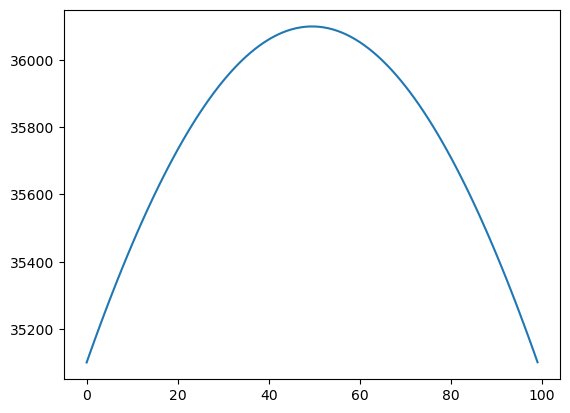

In [174]:
plt.plot(chip1.bottom_topology(chip1.xs) - chip2.top_topology(chip2.xs) + chip1.get_dofs('bottom') - chip2.get_dofs('top'))